### downloading the dataset of images 
#### Source: Kaggle

In [ ]:
import pandas as pd
df = pd.read_csv("../data/HAM10000_metadata.csv")
print(df.head())

In [ ]:
import cv2
import numpy as np
import os

def load_images(image_dir, df, size=(64,64)):
    images = []
    labels = []
    for i, row in df.iterrows():
        img_path = os.path.join(image_dir, row['image_id'] + ".jpg")
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, size)
            images.append(img / 255.0)  # normalize
            labels.append(row['dx'])
    return np.array(images), labels


In [ ]:
images, labels = load_images("../data/HAM10000_images_part_1", df, size=(64,64))
print(f"Loaded {len(images)} images and {len(labels)} labels.")


In [ ]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels) 
labels_categorical = to_categorical(labels_encoded)  

### Model TRaining

In [ ]:

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split

# Split data into train and test
X_train, X_test, y_train, y_test = train_test_split(images, labels_categorical, test_size=0.2, random_state=42)

model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(64, 64, 3)),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(y_train.shape[1], activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Model training
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Save the model in the recommended Keras format
model.save('../model/model.keras')


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)
datagen.fit(X_train)

# Train the model using augmented data
enhanced_history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    epochs=10,
    validation_data=(X_test, y_test)
)

In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Use MobileNetV2 as the base model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(64, 64, 3))
base_model.trainable = False  # Freeze base model

# Add custom layers on top
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(y_train.shape[1], activation='softmax')(x)

transfer_model = Model(inputs=base_model.input, outputs=predictions)
transfer_model.compile(optimizer=Adam(learning_rate=0.0005), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the transfer learning model
transfer_history = transfer_model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    epochs=10,
    validation_data=(X_test, y_test)
)

# Save the transfer learning model
transfer_model.save('../model/transfer_model.keras')

In [ ]:
print(f"Number of training images: {len(X_train)}")
print(f"Number of testing images: {len(X_test)}")

### This is the outupt block


#### Training Accuracy
The following plot shows the training and validation accuracy over epochs.

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#### Confusion Matrix
The confusion matrix below shows the performance of the model on the test set.

In [ ]:
import numpy as np

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
pip install seaborn

#### Predictions
Below are sample predictions from the test set, showing the true and predicted labels.

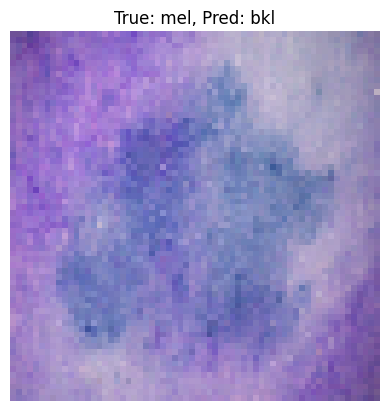

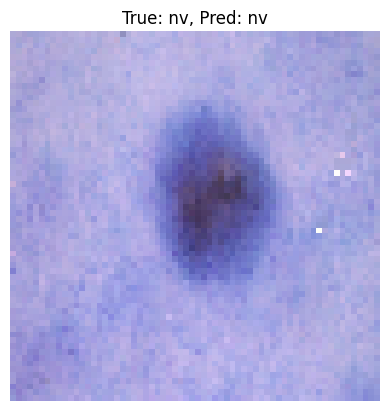

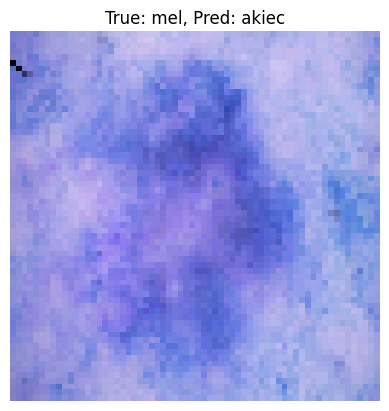

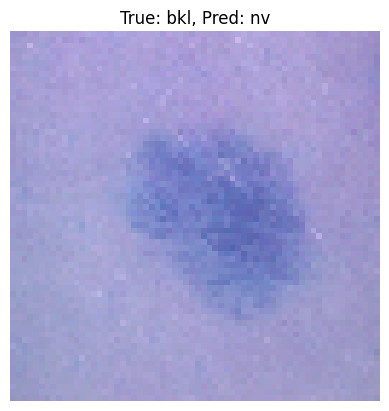

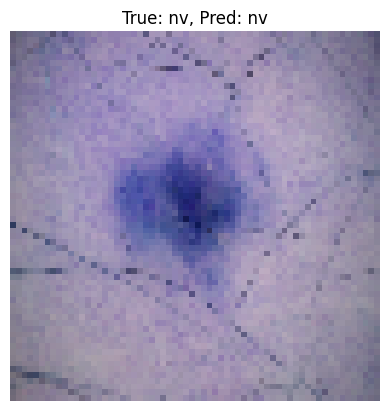

Example prediction image not found. Please add it as example_prediction.png.


In [13]:
# Display a few test images with their predicted and true labels
for i in range(5):
    plt.imshow(X_test[i])
    plt.title(f"True: {label_encoder.classes_[y_true[i]]}, Pred: {label_encoder.classes_[y_pred_classes[i]]}")
    plt.axis('off')
    plt.show()

# Example output image (replace with your own if needed)
from PIL import Image
import io
import base64
from IPython.display import display

# Provided example image (replace with actual file path if available)
img_path = 'example_prediction.png'  # Save the provided image as this file in the notebook directory
try:
    img = Image.open(img_path)
    display(img)
except FileNotFoundError:
    print('Example prediction image not found. Please add it as example_prediction.png.')

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
              precision    recall  f1-score   support

       akiec       0.56      0.20      0.30        69
         bcc       0.43      0.71      0.54        93
         bkl       0.50      0.33      0.40       228
          df       0.00      0.00      0.00        28
         mel       0.48      0.30      0.37       226
          nv       0.82      0.92      0.87      1338
        vasc       0.67      0.67      0.67        21

    accuracy                           0.73      2003
   macro avg       0.49      0.45      0.45      2003
weighted avg       0.70      0.73      0.71      2003



d:\Projects\health-model\skin-cancer-detector\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\Projects\health-model\skin-cancer-detector\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\Projects\health-model\skin-cancer-detector\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mod

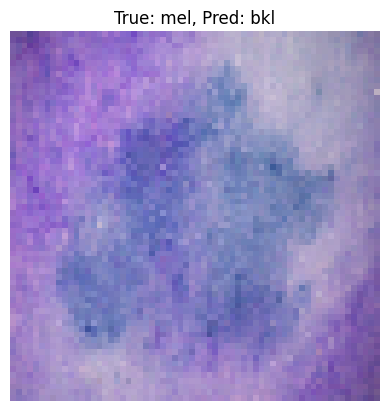

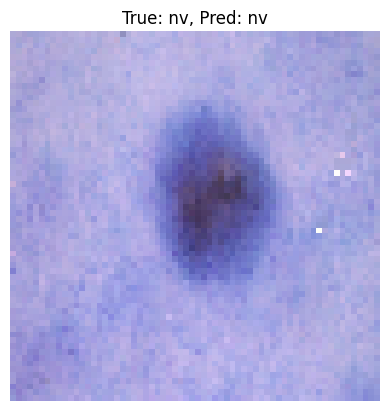

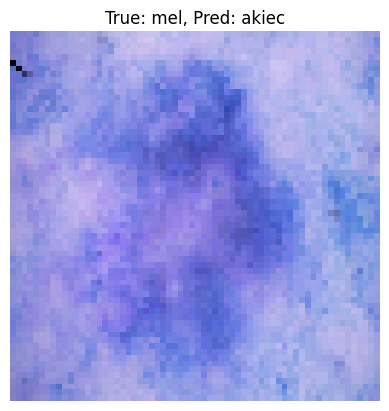

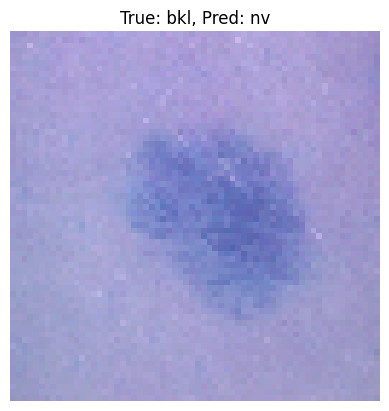

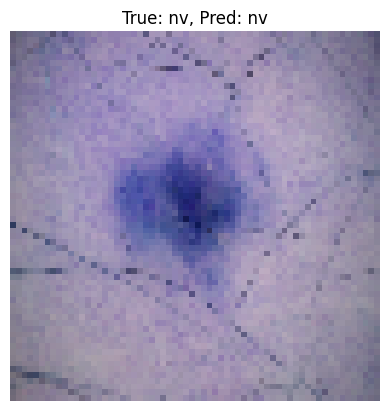

In [14]:

import numpy as np
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

# Predict class probabilities and get class indices
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)


print(classification_report(y_true, y_pred_classes, target_names=label_encoder.classes_))

# Display a few test images with their predicted and true labels
for i in range(5):
    plt.imshow(X_test[i])
    plt.title(f"True: {label_encoder.classes_[y_true[i]]}, Pred: {label_encoder.classes_[y_pred_classes[i]]}")
    plt.axis('off')
    plt.show()
